In [9]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset_name, transform=None):
        self.dataset_name = dataset_name
        self.transform = transform
        self.dataset= load_dataset("flaviagiammarino/path-vqa")

    def __len__(self):
        return self.dataset[self.dataset_name].num_rows

    def __getitem__(self, idx):
        
        if self.transform:
            image = self.transform(self.dataset[self.dataset_name][idx]['image'].convert('RGB'))

        return image

transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset_train = CustomDataset(dataset_name='train', transform=transform)
dataset_val = CustomDataset(dataset_name='validation', transform=transform)

# DataLoader to load the dataset
batch_size = 16  # Set your desired batch size
train_data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


In [10]:
from torch import Tensor
class WNetDownConvBlock(nn.Module):
    r"""Performs two 3x3 2D convolutions, each followed by a ReLU and batch norm. Ends with a 2D max-pool operation."""

    def __init__(self, in_features: int, out_features: int):
        r"""
        :param in_features: Number of feature channels in the incoming data
        :param out_features: Number of feature channels in the outgoing data
        """
        super(WNetDownConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_features, out_features, 3),
            nn.ReLU(),
            nn.BatchNorm2d(out_features),
            nn.ReplicationPad2d(1),
            nn.Conv2d(out_features, out_features, 3),
            nn.ReLU(),
            nn.BatchNorm2d(out_features),
            nn.ReplicationPad2d(1),
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: Tensor) -> Tensor:
        """Pushes a set of inputs (x) through the network.

        :param x: Input values
        :return: Module outputs
        """
        feature_map = self.layers(x)
        return self.pool(feature_map), feature_map


class WNetUpConvBlock(nn.Module):
    r"""Performs two 3x3 2D convolutions, each followed by a ReLU and batch norm. Ends with a transposed convolution with a stride of 2 on the last layer. Halves features at first and third convolutions"""

    def __init__(self, in_features: int, mid_features: int, out_features: int):
        r"""
        :param in_features: Number of feature channels in the incoming data
        :param out_features: Number of feature channels in the outgoing data
        """
        super(WNetUpConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_features, mid_features, 3),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(),
            nn.ReplicationPad2d(1),
            nn.Conv2d(mid_features, mid_features, 3),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(),
            nn.ReplicationPad2d(1),
            nn.ConvTranspose2d(mid_features, out_features, 2, stride=2),
        )

    def forward(self, x: Tensor) -> Tensor:
        """Pushes a set of inputs (x) through the network.

        :param x: Input values
        :return: Module outputs
        """
        return self.layers(x)


class WNetOutputBlock(nn.Module):
    r"""Performs two 3x3 2D convolutions, each followed by a ReLU and batch Norm.
    Ending with a 1x1 convolution to map features to classes."""

    def __init__(self, in_features: int, num_classes: int):
        r"""
        :param in_features: Number of feature channels in the incoming data
        :param num_classes: Number of feature channels in the outgoing data
        """
        super(WNetOutputBlock, self).__init__()
        mid_features = int(in_features / 2)
        self.layers = nn.Sequential(
            nn.Conv2d(in_features, mid_features, 3),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(),
            nn.ReplicationPad2d(1),
            nn.Conv2d(mid_features, mid_features, 3),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(),
            nn.ReplicationPad2d(1),

            # 1x1 convolution to map features to classes
            nn.Conv2d(mid_features, num_classes, 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        """Pushes a set of inputs (x) through the network.

        :param x: Input values
        :return: Module outputs
        """
        return self.layers(x)

# TODO: seperable convolutions

class UNetAuto(nn.Module):
    r"""UNet based architecture for image auto encoding"""

    def __init__(self, num_channels: int = 3, num_out_channels: int = 3, max_features: int = 1024):
        r"""
        :param num_channels: Number of channels in the raw image data
        :param num_out_channels: Number of channels in the output data
        """
        super(UNetAuto, self).__init__()
        if max_features not in [1024, 512, 256]:
            print('Max features restricted to [1024, 512, 256]')
            max_features = 1024
        features_4 = max_features // 2
        features_3 = features_4 // 2
        features_2 = features_3 // 2
        features_1 = features_2 // 2

        self.conv_block1 = WNetDownConvBlock(num_channels, features_1)
        self.conv_block2 = WNetDownConvBlock(features_1, features_2)
        self.conv_block3 = WNetDownConvBlock(features_2, features_3)
        self.conv_block4 = WNetDownConvBlock(features_3, features_4)

        self.deconv_block1 = WNetUpConvBlock(features_4, max_features, features_4)
        self.deconv_block2 = WNetUpConvBlock(max_features, features_4, features_3)
        self.deconv_block3 = WNetUpConvBlock(features_4, features_3, features_2)
        self.deconv_block4 = WNetUpConvBlock(features_3, features_2, features_1)

        self.output_block = WNetOutputBlock(features_2, num_out_channels)

    def forward(self, x: Tensor) -> Tensor:
        """Pushes a set of inputs (x) through the network.

        :param x: Input values
        :return: Network output Tensor
        """
        # print(f'Block: 0 Curr shape: {x.shape}')
        x, c1 = self.conv_block1(x)
        # print(f'Block: 1 Out shape: {x.shape}; features shape: {c1.shape}')
        x, c2 = self.conv_block2(x)
        # print(f'Block: 2 Out shape: {x.shape}; features shape: {c2.shape}')
        x, c3 = self.conv_block3(x)
        # print(f'Block: 3 Out shape: {x.shape}; features shape: {c3.shape}')
        x, c4 = self.conv_block4(x)
        # print(f'Block: 4 Out shape: {x.shape}; features shape: {c4.shape}')
        d1 = self.deconv_block1(x)
        # print(f'Block: 5 Out shape: {d1.shape}')
        d2 = self.deconv_block2(torch.cat((c4, d1), dim=1))
        # print(f'Block: 6 Out shape: {d2.shape}')
        d3 = self.deconv_block3(torch.cat((c3, d2), dim=1))
        # print(f'Block: 7 Out shape: {d3.shape}')
        d4 = self.deconv_block4(torch.cat((c2, d3), dim=1))
        # print(f'Block: 8 Out shape: {d4.shape}')
        out = self.output_block(torch.cat((c1, d4), dim=1))
        # print(f'Block: 9 Out shape: {out.shape}')

        return out

In [11]:
device="cuda"
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    T=epochs*len(train_loader)
    T0=T/5
    n_max=0.006/10
    t=0
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        running_loss_error=0.0
        if epoch%5==0:
          for op_params in optimizer.param_groups:
            op_params['lr'] /= 10
        model.train()
        for i, (images) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = images.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # print(predicted.shape)
            # correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            # if plot:
            #   info = { ('loss_' + model_name): loss.item() }

            # for op_params in optimizer.param_groups:
            #     if t<=T0:
            #         op_params['lr']=0.0001 + (t/T0)*n_max
            #     else:
            #         op_params['lr']=n_max*np.cos(np.pi*0.5*((t-T0)/(T-T0))) + 0.000001

            # t+=1

        train_loss_values.append(running_loss/len(train_loader))
        #train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images) in enumerate(test_loader):
                images = images.to(device)
                labels = images.to(device)
                outputs = model(images)
                loss_error = criterion(outputs, labels)
                running_loss_error += loss_error.item()
                # _, predicted = torch.max(outputs.data, 1)
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

        print('Loss of the network on the test images: {} %'.format(running_loss_error/len(test_loader)))
        #val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss_error/len(test_loader))
        
    return val_error,val_loss_values,train_error,train_loss_values

In [12]:
# model = UNetAuto(max_features=512).to(device)
# epochs = 50
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
# val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs, 'cnn_curve', True)
# torch.save(model.state_dict(), "model_parameters_Unet.pth")
# torch.save('val_error_c.pt')
# torch.save('val_loss_values_c.pt')
# torch.save('train_errorr_c.pt')
# torch.save('train_loss_values_c.pt')

In [13]:
device="cuda"
model = UNetAuto(max_features=512).to(device)
model.load_state_dict(torch.load("model_parameters_Unet.pth"))

<All keys matched successfully>

NameError: name 'train_loss_values' is not defined

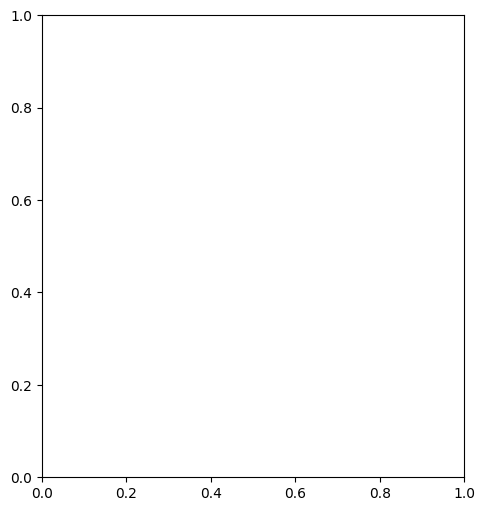

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values)
plt.title('Training Error')
plt.xlabel('Number of Epochs')
plt.ylabel('Error')

# Plotting the training error.
plt.subplot(1, 2, 2)
plt.plot(val_loss_values)
plt.title('Validation Error')
plt.xlabel('Number of Epochs')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

In [22]:
images_list=[]
print(images)
for i, (images1) in enumerate(train_data_loader):
            # Move tensors to configured device
            images = images1.to(device)
            labels = images1.to(device)
            print(images.shape)
            #Forward Pass
            outputs = model(images)
            print(i)
            for x in range(outputs.data.shape[0]):

                # plt.subplot(i+1, 2, 1)
                # plt.imshow(outputs.data[x].permute(1,2,0).cpu())
                # plt.subplot(i+1, 2, 2)
                # plt.imshow(images1[x].permute(1,2,0))
                # plt.plot()
                images_list.append(images1[x].permute(1,2,0))
                images_list.append(outputs.data[x].permute(1,2,0).cpu())
                

            if i == 10:
                break
                
            
            

tensor([[[[0.6549, 0.7373, 0.7373,  ..., 0.5882, 0.5725, 0.6353],
          [0.6627, 0.7373, 0.7451,  ..., 0.5922, 0.5882, 0.6431],
          [0.6941, 0.6784, 0.6510,  ..., 0.6549, 0.7412, 0.8235],
          ...,
          [0.7529, 0.7569, 0.6471,  ..., 0.9647, 0.9373, 0.8941],
          [0.6627, 0.5843, 0.3922,  ..., 0.9529, 0.9412, 0.8627],
          [0.5569, 0.3373, 0.3216,  ..., 0.9333, 0.9569, 0.9451]],

         [[0.0784, 0.1059, 0.1020,  ..., 0.0902, 0.0824, 0.1137],
          [0.0706, 0.1059, 0.1176,  ..., 0.0902, 0.1137, 0.1412],
          [0.0902, 0.0863, 0.0863,  ..., 0.0941, 0.2706, 0.4549],
          ...,
          [0.4745, 0.4118, 0.2706,  ..., 0.7686, 0.7412, 0.6863],
          [0.3176, 0.2471, 0.1020,  ..., 0.7647, 0.7843, 0.6549],
          [0.2667, 0.1216, 0.1137,  ..., 0.7294, 0.7961, 0.7765]],

         [[0.2784, 0.3059, 0.2784,  ..., 0.2667, 0.2627, 0.3216],
          [0.2431, 0.2980, 0.3020,  ..., 0.2784, 0.3020, 0.3412],
          [0.2549, 0.2784, 0.2745,  ..., 0

In [25]:
len(images_list)

352

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


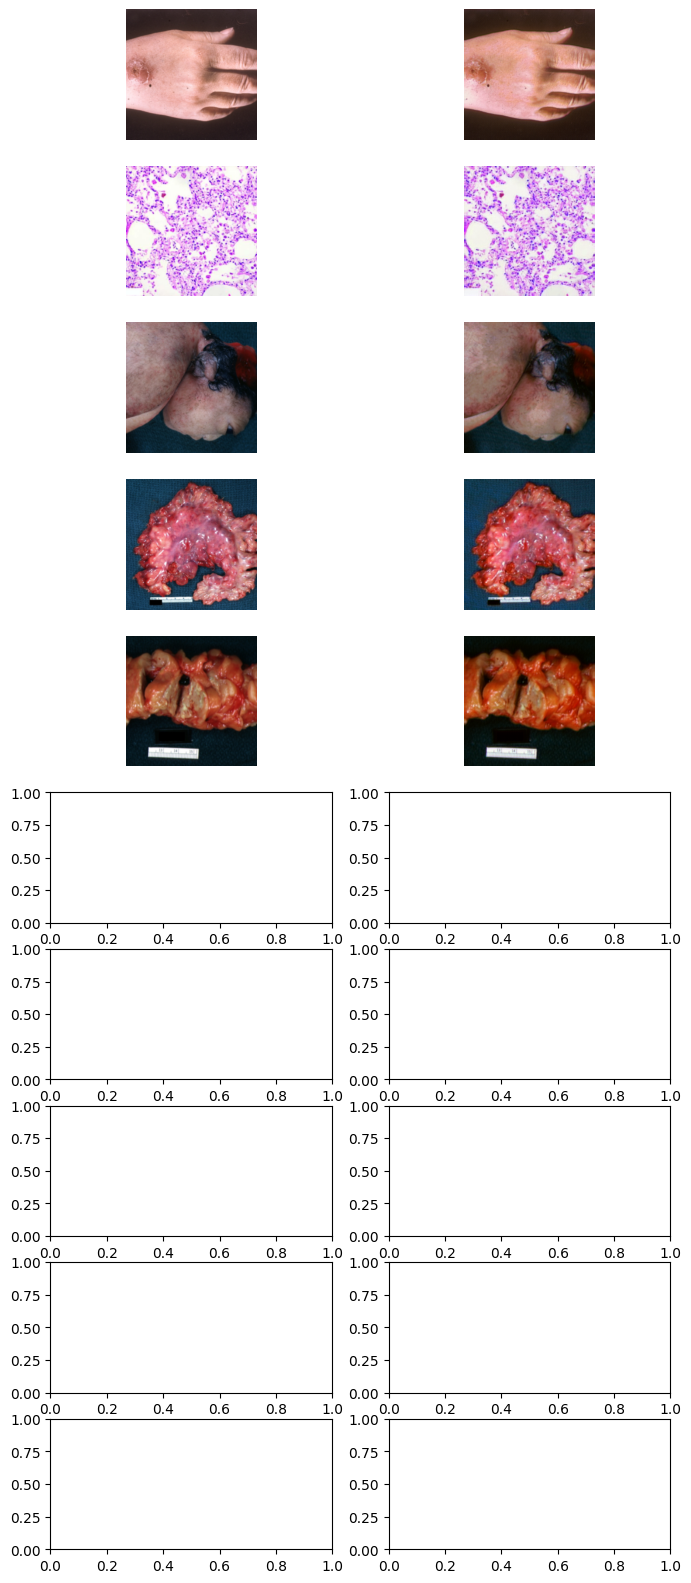

In [23]:
fig, axs = plt.subplots(10, 2, figsize=(8, 20))  # Adjust figsize as needed
for i in range(10):
    for j in range(2):
        index = i * 2 + j
        if index < 10:
            axs[i, j].imshow(images_list[index], cmap='gray')  # Change the cmap as needed
            axs[i, j].axis('off')